In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
plt.rcParams.update({'font.size': 10})
import pandas as pd
import os
import glob
from mpl_toolkits.mplot3d import Axes3D
import re
from scipy.optimize import fsolve

# Equations

In [102]:
def R_inv(A_cont, A_I):
    return np.sqrt((1 - ((2 * A_cont)/A_I - 1)**2)/A_cont)/2

def dR_invdAI(A_cont, A_I):
    return - (A_I - 2 * A_cont)/(A_I**2 * np.sqrt(A_I - A_cont))/2

def dR_invdA_cont(A_cont, A_I):
    return - 1 / (2 * A_I * np.sqrt(A_I - A_cont))

# Equilibrium values in case of c=0
def N_fI_sort(N_f, A_I, e):
    gamma = 1 / (1 + np.exp(-e))
    return ((A_I + N_f)*(1-gamma) +  gamma
            - np.sqrt(-4 * A_I * N_f * (1 - gamma) 
                    + ((A_I + N_f)*(1- gamma) + gamma)**2)) / (2 * (1 - gamma))

def N_dI_sort(N_f, N_d, A_I, e):
    gamma = 1 / (1 + np.exp(-e))
    return (-A_I * N_d + (A_I * N_d) / (2 * (1 - gamma)) + (N_f * N_d) / (2 * (1 - gamma)) 
            + (N_d * gamma) / (2 * (1 - gamma)) - (A_I * N_d * gamma) / (2 * (1 - gamma)) - (N_f * N_d * gamma) / (2 * (1 - gamma)) 
            - (N_d * np.sqrt(-4 * A_I * N_f * (1 - gamma) + (A_I + N_f + gamma - A_I * gamma - N_f * gamma)**2)) / (2 * (1 - gamma)))/(N_f - 1)

In [103]:
def A_I_dot(A_I, A_cont, k, C0, c, N_fI, N_dI, N_f, N_d, e):
    gamma = 1 / (1 + np.exp(-e))
    entropic_contribution = np.log((A_I * ((1 - A_I) - ((N_f + N_d) - (N_fI + N_dI)))) 
                                   / ((A_I - (N_fI + N_dI)) * (1 - A_I)))
    N_I = N_fI + N_dI
    N_II = N_f + N_d - N_I
    C_I = c * N_I / A_I
    C_II = c * N_II / (1 - A_I)
    
    return entropic_contribution - 2 * k * ((R_inv(A_cont,A_I) - C0 - C_I)**2 - (R_inv(A_cont,1-A_I) - C0 - C_II)**2 
                                            + 2 * A_I * (R_inv(A_cont,A_I) - C0 - C_I) * (dR_invdAI(A_cont, A_I)+C_I/A_I) 
                                            - 2 * (1-A_I) * (R_inv(A_cont,1-A_I) - C0 - C_II) * (dR_invdAI(A_cont, 1-A_I)+C_II/(1-A_I)))

def A_cont_dot(A_I, A_cont, k, z, C0, c, N_fI, N_dI, N_f, N_d):
    
    N_I = N_fI + N_dI
    N_II = N_f + N_d - N_I
    C_I = c * N_I / A_I
    C_II = c * N_II / (1 - A_I)
    
    return -4 * k * (A_I * (R_inv(A_cont,A_I) - C0 - C_I) * dR_invdA_cont(A_cont, A_I) 
                           + (1-A_I) * (R_inv(A_cont,1-A_I) - C0 - C_II) * dR_invdA_cont(A_cont, 1-A_I))  - z*np.sqrt(np.pi)/np.sqrt(A_cont)

In [104]:
def find_flow(A_I, A_cont, N_f, N_d, e, z, k, C0, c):
    """ Solve N_fI_dyn and N_dI_dyn assuming equilibrium """
    
    if (A_cont < A_I) & (A_cont < (1 - A_I)) & (A_cont>0):
        gamma = 1/(1+np.exp(-e))
        def equations(vars):
            N_fI_dyn, N_dI_dyn = vars
            N_I_dyn = N_fI_dyn + N_dI_dyn
            N_II_dyn = N_f + N_d - N_I_dyn

            C_I = c * N_I_dyn / A_I
            C_II = c * N_II_dyn / (1 - A_I)

            eq1 = -np.log((gamma * N_fI_dyn * (1 - A_I - N_II_dyn)) / ((A_I - N_I_dyn) * (N_f - N_fI_dyn))) + 4 * k * c * ((R_inv(A_cont, A_I) - C0 - C_I) - (R_inv(A_cont, 1 - A_I) - C0 - C_II))
            eq2 = -np.log((N_dI_dyn * (1 - A_I - N_II_dyn)) / ((A_I - N_I_dyn) * (N_d - N_dI_dyn))) + 4 * k * c * ((R_inv(A_cont, A_I) - C0 - C_I) - (R_inv(A_cont, 1 - A_I) - C0 - C_II))
            
            return [eq1, eq2]

        # Initial guess: equal partitioning
        N_fI_guess = N_fI_sort(N_f, A_I, e)
        N_dI_guess = N_dI_sort(N_f, N_d, A_I, e)

        N_fI_equi, N_dI_equi = fsolve(equations, [N_fI_guess, N_dI_guess])


        return A_I_dot(A_I, A_cont, k, C0, c, N_fI_equi, N_dI_equi, N_f, N_d, e), A_cont_dot(A_I, A_cont, k, z, C0, c, N_fI_equi, N_dI_equi, N_f, N_d)
    else:
        return None, None

# Vectorize the function to apply it to arrays
vectorized_find_flow = np.vectorize(find_flow, otypes=[float, float])

# Parameters and flow grid

In [105]:
asize = 0.1 # The free energy is rescaled by a/A in Matlab

kappa = 20
zeta = 18
C0 = 0.4
c = 0
epsilon = -1
N = 0.1
Nf = N/2
Nd = N/2

A_I_vals = np.linspace(0, 1, 200)
A_cont_vals = np.linspace(0, 0.5, 200)

A_I_grid, A_cont_grid = np.meshgrid(A_I_vals, A_cont_vals)

# Masking invalid geometries
mask = (A_cont_grid > 0) & (A_cont_grid < A_I_grid) & (A_cont_grid < (1 - A_I_grid))


# Perfect sphere condition
sphere = A_I_vals - A_I_vals**2 # RuntimeWarning due to forbidden geometries (A_cont < 0 | A_cont > A_I | A_cont > A - A_I)

# Import bifurcation diagram and plot

In [106]:
# Folder path where the CSV files are stored
directory = r'C:\Users\lenovo\Documents\Masterarbeit\Programming\output\Bifurcations_particles'

In [110]:
# Function to plot a plane in zeta dimension
def plot_plane_at_x(ax, x_value):
    # Create a meshgrid
    y = np.linspace(0, 1, 1000)
    z = np.linspace(0, 0.5, 1000)
    Y, Z = np.meshgrid(y, z)

    X = np.full_like(Y, x_value)

    # Plot the surface
    ax.plot_surface(X, Y, Z, color='gray', alpha=0.3, rstride=5, cstride=5)
    
# Function to plot branches in 3D
def plot_branch_3D(branch, ax, x_value=None):
    global bp_label_added, lp_label_added
    # Identify limit points (LPs)
    lp_indices = branch.index[branch[5] == 4].tolist()
    
    # Split the branch at LPs
    split_indices = [branch.index[0]] + lp_indices + [branch.index[-1]]
    branch_segments = [branch.loc[split_indices[i]:split_indices[i+1]] for i in range(len(split_indices)-1)]

    # Stability styles
    stability_styles = {0: ':', 1: '--', 2: '-'}

    for segment in branch_segments:
        for stability, linestyle in stability_styles.items():
            subset = segment[segment[5] == stability]

            if subset.empty:
                continue

            ax.plot(subset[4].values, subset[0].values, subset[1].values, linestyle=linestyle, lw = 1, color='black')
        
            # Plot FPs
            if x_value:
                # Scatter points for FPs
                FP = subset.iloc[(subset[4] - x_value).abs().argmin()]

                # Plot FPs based on stability
                if FP[5] == 2:
                    ax.scatter(FP[4], FP[0], FP[1], marker='o', c='black', s=50, zorder = 3) 
                elif FP[5] == 1:
                    ax.scatter(FP[4], FP[0], FP[1], marker=MarkerStyle('o', fillstyle='right'), c='black', s=50, zorder=3)
                    ax.scatter(FP[4], FP[0], FP[1], marker=MarkerStyle('o', fillstyle='left'), c='white', edgecolor = 'black', s=50, zorder=3)
                elif FP[5] == 0:
                    ax.scatter(FP[4], FP[0], FP[1], marker='o', c='white', edgecolor = 'black', s=50, zorder = 3)



    # Scatter points for BP and LP
    bp_points = branch[branch[5] == 3]
    lp_points = branch[(branch[5] == 4) & (branch[1]>0.01)] # Ignore "false" FPs
    
    if not bp_label_added:
        ax.scatter(bp_points[4].values, bp_points[0].values, bp_points[1].values, s=50, color=scatter_colorstyle["BP"], marker = 'd', edgecolor = 'black', label="Branching Point", zorder = 5)
        bp_label_added = True
    else:
        ax.scatter(bp_points[4].values, bp_points[0].values, bp_points[1].values, s=50, color=scatter_colorstyle["BP"], marker = 'd', edgecolor = 'black', zorder = 5)

    if not lp_label_added:
        ax.scatter(lp_points[4].values, lp_points[0].values, lp_points[1].values, s=50, color=scatter_colorstyle["LP"], marker = 'd', edgecolor = 'black', label="Limit Point", zorder = 5)
        lp_label_added = True
    else:
        ax.scatter(lp_points[4].values, lp_points[0].values, lp_points[1].values, s=50, color=scatter_colorstyle["LP"], marker = 'd', edgecolor = 'black', zorder = 5)       
        

# Function to plot branches in 2D           
def plot_branch_2D(branch, ax1, ax2, ax3, x_value=None):
    global bp_label_added, lp_label_added
    
    # Identify limit points (LPs)
    lp_indices = branch.index[branch[5] == 4].tolist()
    
    # Split the branch at LPs
    split_indices = [branch.index[0]] + lp_indices + [branch.index[-1]]
    branch_segments = [branch.loc[split_indices[i]:split_indices[i+1]] for i in range(len(split_indices)-1)]
    
    # Stability styles
    stability_styles = {0: ':', 1: '--', 2: '-'}

    for segment in branch_segments:
        for stability, linestyle in stability_styles.items():
            subset = segment[segment[5] == stability]

            if subset.empty:
                continue

            ax1.plot(subset[4].values, subset[1].values, linestyle=linestyle, lw = 1, color='black')
            ax2.plot(subset[4].values, subset[0].values, linestyle=linestyle, lw = 1, color='black')
        
            # Plot FPs
            if x_value:
                # Scatter points for FPs
                FP = subset.iloc[(subset[4] - x_value).abs().argmin()]

                # Plot FPs based on stability
                if FP[5] == 2:
                    ax1.scatter(x_value, FP[1], marker= 'o', c='black', s=50, zorder = 3) 
                    ax2.scatter(x_value, FP[0], marker= 'o', c='black', s=50, zorder = 3) 
                    ax3.scatter(FP[0], FP[1], marker= 'o', c='black', s=50, zorder = 3) 
                elif FP[5] == 1:
                    ax1.scatter(x_value, FP[1], marker=MarkerStyle('o', fillstyle='right'), c='black', s=50, zorder = 3) 
                    ax1.scatter(x_value, FP[1], marker=MarkerStyle('o', fillstyle='left'), c='white', edgecolor = 'black', s=50, zorder = 3)
                    ax2.scatter(x_value, FP[0], marker=MarkerStyle('o', fillstyle='right'), c='black', s=50, zorder = 3) 
                    ax2.scatter(x_value, FP[0], marker=MarkerStyle('o', fillstyle='left'), c='white', edgecolor = 'black', s=50, zorder = 3)
                    ax3.scatter(FP[0], FP[1], marker=MarkerStyle('o', fillstyle='right'), c='black', s=50, zorder = 3) 
                    ax3.scatter(FP[0], FP[1], marker=MarkerStyle('o', fillstyle='left'), c='white', edgecolor = 'black', s=50, zorder = 3)
                elif FP[5] == 0: 
                    ax1.scatter(x_value, FP[1], marker= 'o', c='white', edgecolor = 'black', s=50, zorder = 3)
                    ax2.scatter(x_value, FP[0], marker= 'o', c='white', edgecolor = 'black', s=50, zorder = 3)
                    ax3.scatter(FP[0], FP[1], marker= 'o', c='white', edgecolor = 'black', s=50, zorder = 3)
                    ax3.axhline(y=FP[1], linestyle=':', color='gray')
                    print(FP[1])

        

    # Scatter points for BP and LP
    bp_points = branch[branch[5] == 3]
    lp_points = branch[(branch[5] == 4) & (branch[1]>0.01)] # Ignore "false" FPs

    ax1.scatter(bp_points[4].values, bp_points[1].values, s=50, color=scatter_colorstyle["BP"], marker = 'd', edgecolor = 'black', zorder = 3)
    ax2.scatter(bp_points[4].values, bp_points[0].values, s=50, color=scatter_colorstyle["BP"], marker = 'd', edgecolor = 'black', zorder = 3)
    ax1.scatter(lp_points[4].values, lp_points[1].values, s=50, color=scatter_colorstyle["LP"], marker = 'd', edgecolor = 'black', zorder = 3)
    ax2.scatter(lp_points[4].values, lp_points[0].values, s=50, color=scatter_colorstyle["LP"], marker = 'd', edgecolor = 'black', zorder = 3)

    
def plot_flow(ax, epsilon, kappa, zeta, C0, c, transparency = 1, legend = False):
    # Compute flow fields
    A_I_dot_grid, A_cont_dot_grid = vectorized_find_flow(A_I_grid, A_cont_grid, Nf, Nd, epsilon, zeta, kappa, C0, c)

    # Convert possible None values to NaN for consistency
    A_I_dot_grid = np.where(np.isnan(A_I_dot_grid), np.nan, A_I_dot_grid)
    A_cont_dot_grid = np.where(np.isnan(A_cont_dot_grid), np.nan, A_cont_dot_grid)

    ax.streamplot(A_I_grid, A_cont_grid, A_I_dot_grid, A_cont_dot_grid, color = 'grey', linewidth=1)
    
    # Plot spherical condition and nullclines
    sphere_contour = ax.plot(A_I_vals, sphere, color=plt.cm.viridis(0.3), linewidth=3, label="Sphere", alpha = transparency)
    A_I_dot_contour = ax.contour(A_I_grid, A_cont_grid, A_I_dot_grid, levels=0, colors=plt.cm.viridis(0.1), linewidths=2, alpha = transparency)
    A_cont_dot_contour = ax.contour(A_I_grid, A_cont_grid, A_cont_dot_grid, levels=0, colors=plt.cm.viridis(0.7), linewidths=2, alpha = transparency)

    # Add black diagonal lines
    ax.plot(np.linspace(0, 0.5, 1000), np.linspace(0, 0.5, 1000), linewidth=0.5, color='black')
    ax.plot(np.linspace(0.5, 1, 1000), 1 - np.linspace(0.5, 1, 1000), linewidth=0.5, color='black')

     # Manually create legend handles
    if legend:
        legend_handles = [
        Line2D([0], [0], color=plt.cm.viridis(0.3), linewidth=5, label="Spherical Condition", alpha = transparency),
        Line2D([0], [0], color=plt.cm.viridis(0.1), linewidth=2, linestyle='-', label=r'$\dot{\alpha_I}=0$', alpha = transparency),
        Line2D([0], [0], color=plt.cm.viridis(0.7), linewidth=2, linestyle='-', label=r'$\dot{\alpha}_{cont}=0$', alpha = transparency),
        ]
        # Add the legend
        ax.legend(handles=legend_handles, loc="upper right")
    
    ax.set_aspect(2)
    
    ax.set_xlabel('Area with\n'+ r'binding sites $\alpha_I$', fontweight='bold')
    ax.set_ylabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', fontweight='bold')
    
def find_equilib(A_I, A_cont, N_f, N_d, e, z, k, C0, c):
    """ Solve N_fI_dyn and N_dI_dyn assuming equilibrium """
    
    if ((A_cont+1e-3) < min(A_I, 1-A_I)) and ((A_cont-1e-03)>0):
        gamma = 1/(1+np.exp(-e))
        def equations(vars):
            N_fI_dyn, N_dI_dyn = vars
            N_I_dyn = N_fI_dyn + N_dI_dyn
            N_II_dyn = N_f + N_d - N_I_dyn

            C_I = c * N_I_dyn / A_I
            C_II = c * N_II_dyn / (1 - A_I)

            eq1 = -np.log((gamma * N_fI_dyn * (1 - A_I - N_II_dyn)) / ((A_I - N_I_dyn) * (N_f - N_fI_dyn))) + 4 * k * c * ((R_inv(A_cont, A_I) - C0 - C_I) - (R_inv(A_cont, 1 - A_I) - C0 - C_II))
            eq2 = -np.log((N_dI_dyn * (1 - A_I - N_II_dyn)) / ((A_I - N_I_dyn) * (N_d - N_dI_dyn))) + 4 * k * c * ((R_inv(A_cont, A_I) - C0 - C_I) - (R_inv(A_cont, 1 - A_I) - C0 - C_II))
            
            return [eq1, eq2]

        # Initial guess: equal partitioning
        N_fI_guess = N_fI_sort(N_f, A_I, e)
        N_dI_guess = N_dI_sort(N_f, N_d, A_I, e)

        N_fI_equi, N_dI_equi = fsolve(equations, [N_fI_guess, N_dI_guess]) # Error message for the two nullclines aligning

        return (N_fI_equi-N_fI_guess)/N_f*100, (N_dI_equi-N_dI_guess)/N_d*100
    else:
        return None, None
    
vectorized_find_equilib = np.vectorize(find_equilib, otypes=[float, float])

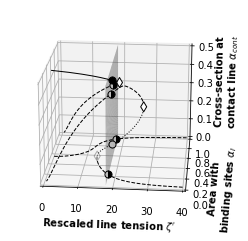

0.083035


C:\Users\lenovo\AppData\Local\Temp/ipykernel_7580/784403457.py:14: RuntimeWarning: invalid value encountered in log
  eq1 = -np.log((gamma * N_fI_dyn * (1 - A_I - N_II_dyn)) / ((A_I - N_I_dyn) * (N_f - N_fI_dyn))) + 4 * k * c * ((R_inv(A_cont, A_I) - C0 - C_I) - (R_inv(A_cont, 1 - A_I) - C0 - C_II))
C:\Users\lenovo\AppData\Local\Temp/ipykernel_7580/784403457.py:15: RuntimeWarning: invalid value encountered in log
  eq2 = -np.log((N_dI_dyn * (1 - A_I - N_II_dyn)) / ((A_I - N_I_dyn) * (N_d - N_dI_dyn))) + 4 * k * c * ((R_inv(A_cont, A_I) - C0 - C_I) - (R_inv(A_cont, 1 - A_I) - C0 - C_II))
C:\Users\lenovo\AppData\Local\Temp/ipykernel_7580/784403457.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  N_fI_equi, N_dI_equi = fsolve(equations, [N_fI_guess, N_dI_guess])


KeyboardInterrupt: 

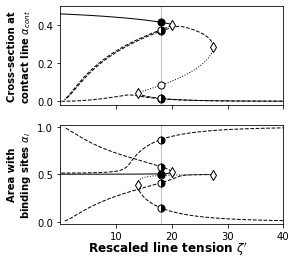

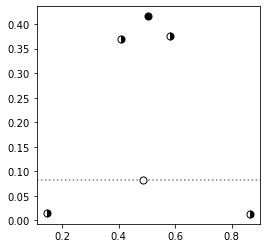

In [111]:
# Load main and side branches
branch_1 = pd.read_csv(os.path.join(directory, f'Branch_c_0_1.csv'), header=None)
branch_2 = pd.read_csv(os.path.join(directory, f'Branch_c_0_2.csv'), header=None)
branch_3 = pd.read_csv(os.path.join(directory, f'Branch_c_0_3.csv'), header=None)

branch_1 = branch_1[branch_1[4]<=4]
branch_2 = branch_2[branch_2[4]<=4]
branch_3 = branch_3[branch_3[4]<=4]

branch_1[4] = branch_1[4]/asize
branch_2[4] = branch_2[4]/asize
branch_3[4] = branch_3[4]/asize

# Track if labels have been added
bp_label_added = False
lp_label_added = False
# Define filling for scatter points
scatter_colorstyle = {"BP": 'black', "LP": 'white'}

####################################################################################
# 3D bifurcation diagram
fig_3D = plt.figure(figsize=(6, 4))
ax3D = fig_3D.add_subplot(111, projection='3d')

plot_branch_3D(branch_1, ax3D, zeta)
plot_branch_3D(branch_2, ax3D, zeta)
plot_branch_3D(branch_3, ax3D, zeta)
plot_plane_at_x(ax3D, zeta)

# Viewing angle
ax3D.view_init(elev=20, azim=-85)

# Axis limits and labels
ax3D.set_xlim(0, 4/asize)
ax3D.set_ylim(0, 1)
ax3D.set_zlim(0, 0.5)

ax3D.set_xlabel(r"Rescaled line tension $\zeta'$", ha='center', fontweight='bold')
ax3D.set_ylabel('Area with\n' + r'binding sites $\alpha_I$', ha='center', fontweight='bold', labelpad=8)
ax3D.set_zlabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', ha='center', fontweight='bold', labelpad=10)

# Save 3D plot **without labels or legend**
plt.savefig('figures/bifurcation_c_0_3D.png', dpi=300, bbox_inches='tight')
plt.show()

plt.close(fig_3D)

################################################################################################
# 2D bifurcation diagrams and flow diagram FPs
fig_2D, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4), sharex = True)
fig_flow = plt.figure(figsize=(4, 4))
ax3 = fig_flow.add_subplot(111)

plot_branch_2D(branch_1, ax1, ax2, ax3, x_value = zeta)
plot_branch_2D(branch_2, ax1, ax2, ax3, x_value = zeta)
plot_branch_2D(branch_3, ax1, ax2, ax3, x_value = zeta)

ax1.axvline(x=zeta, color='grey', alpha = 0.5, lw = 1)
ax2.axvline(x=zeta, color='grey', alpha = 0.5, lw = 1)

# Labels and limits
ax1.set_ylabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', fontweight='bold')
ax1.set_ylim(-0.02, 0.5)
ax1.set_xlim(0.001, 4/asize)

ax2.set_ylabel('Area with\n'+ r'binding sites $\alpha_I$', fontweight='bold')
ax2.set_ylim(-0.02, 1.02)
ax1.set_xlim(0.001, 4/asize)

ax1.grid(False)
ax2.grid(False)

fig_2D.supxlabel(r"Rescaled line tension $\zeta'$", fontweight='bold')

plot_flow(ax3, epsilon, kappa*asize, zeta*asize, C0, c) 

#Save figures
fig_2D.savefig('figures/bifurcation_c_0_2D.png', dpi=300, bbox_inches='tight')
fig_flow.savefig('figures/bifurcation_flow_c_0.svg', format='svg', dpi=300)
plt.show(fig_2D)
plt.show(fig_flow)
plt.close(fig_flow)
plt.close(fig_2D)

In [112]:
c = 0.3

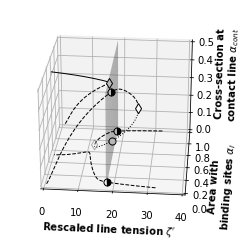

0.089872


C:\Users\lenovo\AppData\Local\Temp/ipykernel_7580/784403457.py:14: RuntimeWarning: invalid value encountered in log
  eq1 = -np.log((gamma * N_fI_dyn * (1 - A_I - N_II_dyn)) / ((A_I - N_I_dyn) * (N_f - N_fI_dyn))) + 4 * k * c * ((R_inv(A_cont, A_I) - C0 - C_I) - (R_inv(A_cont, 1 - A_I) - C0 - C_II))
C:\Users\lenovo\AppData\Local\Temp/ipykernel_7580/784403457.py:15: RuntimeWarning: invalid value encountered in log
  eq2 = -np.log((N_dI_dyn * (1 - A_I - N_II_dyn)) / ((A_I - N_I_dyn) * (N_d - N_dI_dyn))) + 4 * k * c * ((R_inv(A_cont, A_I) - C0 - C_I) - (R_inv(A_cont, 1 - A_I) - C0 - C_II))
C:\Users\lenovo\AppData\Local\Temp/ipykernel_7580/784403457.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  N_fI_equi, N_dI_equi = fsolve(equations, [N_fI_guess, N_dI_guess])


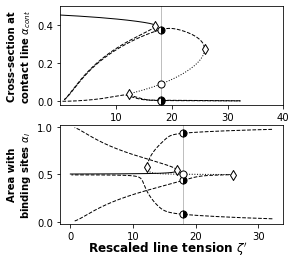

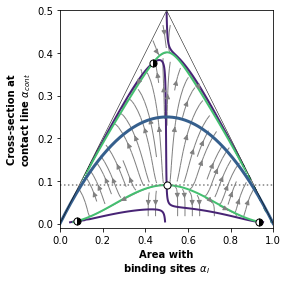

C:\Users\lenovo\AppData\Local\Temp/ipykernel_7580/119931377.py:175: RuntimeWarning: invalid value encountered in log
  eq1 = -np.log((gamma * N_fI_dyn * (1 - A_I - N_II_dyn)) / ((A_I - N_I_dyn) * (N_f - N_fI_dyn))) + 4 * k * c * ((R_inv(A_cont, A_I) - C0 - C_I) - (R_inv(A_cont, 1 - A_I) - C0 - C_II))
C:\Users\lenovo\AppData\Local\Temp/ipykernel_7580/119931377.py:176: RuntimeWarning: invalid value encountered in log
  eq2 = -np.log((N_dI_dyn * (1 - A_I - N_II_dyn)) / ((A_I - N_I_dyn) * (N_d - N_dI_dyn))) + 4 * k * c * ((R_inv(A_cont, A_I) - C0 - C_I) - (R_inv(A_cont, 1 - A_I) - C0 - C_II))
C:\Users\lenovo\AppData\Local\Temp/ipykernel_7580/119931377.py:184: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  N_fI_equi, N_dI_equi = fsolve(equations, [N_fI_guess, N_dI_guess]) # Error message for the two nullclines aligning


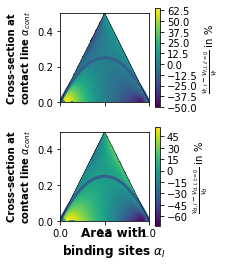

In [113]:
# Load main and side branches
branch_1 = pd.read_csv(os.path.join(directory, f'Branch_c_0.3_1.csv'), header=None)
branch_2 = pd.read_csv(os.path.join(directory, f'Branch_c_0.3_2.csv'), header=None)
branch_3 = pd.read_csv(os.path.join(directory, f'Branch_c_0.3_3.csv'), header=None)

branch_1 = branch_1[branch_1[4]<=4]
branch_2 = branch_2[branch_2[4]<=4]
branch_3 = branch_3[branch_3[4]<=4]

branch_1[4] = branch_1[4]/asize
branch_2[4] = branch_2[4]/asize
branch_3[4] = branch_3[4]/asize

# Track if labels have been added
bp_label_added = False
lp_label_added = False
# Define filling for scatter points
scatter_colorstyle = {"BP": 'black', "LP": 'white'}

####################################################################################
# 3D bifurcation diagram
fig_3D = plt.figure(figsize=(6, 4))
ax3D = fig_3D.add_subplot(111, projection='3d')

plot_branch_3D(branch_1, ax3D, zeta)
plot_branch_3D(branch_2, ax3D, zeta)
plot_branch_3D(branch_3, ax3D)
plot_plane_at_x(ax3D, zeta)

# Viewing angle
ax3D.view_init(elev=25, azim=-85)

# Axis limits and labels
ax3D.set_xlim(0, 4/asize)
ax3D.set_ylim(0, 1)
ax3D.set_zlim(0, 0.5)

ax3D.set_xlabel(r"Rescaled line tension $\zeta'$", ha='center', fontweight='bold')
ax3D.set_ylabel('Area with\n' + r'binding sites $\alpha_I$', ha='center', fontweight='bold', labelpad=8)
ax3D.set_zlabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', ha='center', fontweight='bold', labelpad=10)

# Save 3D plot **without labels or legend**
plt.savefig('figures/bifurcation_c_3D.png', dpi=300, bbox_inches='tight')
plt.show()

plt.close(fig_3D)

################################################################################################
# 2D bifurcation diagrams and flow diagram FPs
fig_2D, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4))
fig_flow = plt.figure(figsize=(4, 4))
ax3 = fig_flow.add_subplot(111)

plot_branch_2D(branch_1, ax1, ax2, ax3, x_value = zeta)
plot_branch_2D(branch_2, ax1, ax2, ax3, x_value = zeta)
plot_branch_2D(branch_3, ax1, ax2, ax3)

ax1.axvline(x=zeta, color='grey', alpha = 0.5, lw = 1)
ax2.axvline(x=zeta, color='grey', alpha = 0.5, lw = 1)

# Labels and limits
ax1.set_ylabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', fontweight='bold')
ax1.set_ylim(-0.02, 0.5)
ax1.set_xlim(0.001, 4/asize)

ax2.set_ylabel('Area with\n'+ r'binding sites $\alpha_I$', fontweight='bold')
ax2.set_ylim(-0.02, 1.02)
ax1.set_xlim(0.001, 4/asize)

ax1.grid(False)
ax2.grid(False)

fig_2D.supxlabel(r"Rescaled line tension $\zeta'$", fontweight='bold')

plot_flow(ax3, epsilon, kappa*asize, zeta*asize, C0, c) # t_n, t_a, zeta, kappa are rescaled by a/A
ax3.set_ylim([-0.01, 0.5])

#Save figures
fig_2D.savefig('figures/bifurcation_c_2D.png', dpi=300, bbox_inches='tight')
fig_flow.savefig('figures/bifurcation_flow_c.svg', format='svg', dpi=300)
plt.show(fig_2D)
plt.show(fig_flow)
plt.close(fig_flow)
plt.close(fig_2D)

#################################################################################################
# Plot change in number equilibrium in a separate figure
fig_nu, (ax_nu1, ax_nu2) = plt.subplots(2, 1, figsize=(2, 4), sharex = True)  # New figure with requested size

N_fI_grid, N_dI_grid = vectorized_find_equilib(A_I_grid, A_cont_grid, Nf, Nd, epsilon, zeta*asize, kappa*asize, C0, c) #the free energy is rescaled by a/A
############### The warning comes for small a_cont, a_i = 0,1: numerical solutions are not found (runs into invalid regions)


# Plot spherical condition and nullclines
ax_nu1.plot(A_I_vals, sphere, color=plt.cm.viridis(0.3), linewidth=3)
ax_nu2.plot(A_I_vals, sphere, color=plt.cm.viridis(0.3), linewidth=3)

# Convert possible None values to NaN for consistency
N_fI_grid = np.where(np.isnan(N_fI_grid), np.nan, N_fI_grid)
N_dI_grid = np.where(np.isnan(N_dI_grid), np.nan, N_dI_grid)

# Plot heatmaps in ax_nu1 and ax_nu2 with shared color scale
cf1 = ax_nu1.contourf(A_I_grid, A_cont_grid, N_fI_grid, cmap='viridis', levels=50)
cf2 = ax_nu2.contourf(A_I_grid, A_cont_grid, N_dI_grid, cmap='viridis', levels=50)

# Add reference lines
for ax in [ax_nu1, ax_nu2]:
    ax.plot(np.linspace(0, 0.5, 1000), np.linspace(0, 0.5, 1000), linewidth=0.5, color='black')
    ax.plot(np.linspace(0.5, 1, 1000), 1 - np.linspace(0.5, 1, 1000), linewidth=0.5, color='black')
    ax.set_ylabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', ha='center', fontweight='bold')

fig_nu.supxlabel('Area with\n'+ r'binding sites $\alpha_I$', fontweight='bold')

# Colorbars with the same scaling
cbar1 = fig_nu.colorbar(cf1, ax=ax_nu1, label=r'$\frac{\nu_{f,I}-\nu_{f,I, \bar{c}=0}}{\nu_f}$ in %')
cbar2 = fig_nu.colorbar(cf2, ax=ax_nu2, label=r'$\frac{\nu_{d,I}-\nu_{d,I, \bar{c}=0}}{\nu_d}$ in %')

ax_nu1.set_aspect(2)
ax_nu2.set_aspect(2)

# Save new figure separately
plt.savefig('figures/bifurcation_nu.svg', format='svg', dpi=300)
plt.show()

# Changing kappa, zeta and invers protein sizes by the same factor leads to the same equilibrium shapes

In [11]:
def plot_flow_supp_info(ax, epsilon, kappa, zeta, C0, c, N):
    N_f = N/2
    N_d = N/2
    # Compute flow fields
    A_I_dot_grid, A_cont_dot_grid = vectorized_find_flow(A_I_grid, A_cont_grid, Nf, Nd, epsilon, zeta, kappa, C0, c)

    # Convert possible None values to NaN for consistency
    A_I_dot_grid = np.where(np.isnan(A_I_dot_grid), np.nan, A_I_dot_grid)
    A_cont_dot_grid = np.where(np.isnan(A_cont_dot_grid), np.nan, A_cont_dot_grid)

    ax.streamplot(A_I_grid, A_cont_grid, A_I_dot_grid, A_cont_dot_grid, color = 'grey', linewidth=1)
    
    # Plot spherical condition and nullclines
    sphere_contour = ax.plot(A_I_vals, sphere, color=plt.cm.viridis(0.3), linewidth=3, label="Spherical Condition")
    A_I_dot_contour = ax.contour(A_I_grid, A_cont_grid, A_I_dot_grid, levels=0, colors=plt.cm.viridis(0.1), linewidths=2)
    A_cont_dot_contour = ax.contour(A_I_grid, A_cont_grid, A_cont_dot_grid, levels=0, colors=plt.cm.viridis(0.7), linewidths=2)

    # Add black diagonal lines
    ax.plot(np.linspace(0, 0.5, 1000), np.linspace(0, 0.5, 1000), linewidth=0.5, color='black')
    ax.plot(np.linspace(0.5, 1, 1000), 1 - np.linspace(0.5, 1, 1000), linewidth=0.5, color='black')
    
    ax.set_aspect(2)
    
    ax.set_xlabel('Area with\n'+ r'binding sites $\alpha_I$', fontweight='bold')
    ax.set_ylabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', fontweight='bold')

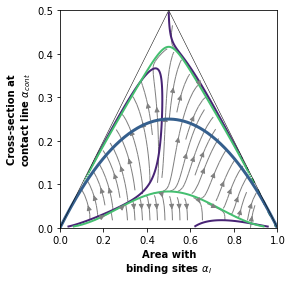

In [35]:
################################################################################################
asize = 0.001 # NPC example
# 2D bifurcation diagrams and flow diagram FPs
fig_flow = plt.figure(figsize=(4, 4))
ax = fig_flow.add_subplot(111)

plot_flow_supp_info(ax, -1, 200*asize, 180*asize, 0.4, 0, 0.1) #The total free energy is rescaled by a/A
fig_flow.savefig('figures/flow_small_a_NPC.svg', dpi=300, bbox_inches='tight')